In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
import time
import torch
import tiktoken

from transformers import GPT2Model

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

from gepeto.train_classifier import (
    calc_precision_loader,
    calc_loss_loader,
    calc_accuracy_loader,
    train_classifier_simple,
)
from gepeto.model import MODEL_ARCHITECTURES, GPTModel
from gepeto.loader import SpamSMSDataset
from gepeto.utils import value_counts, load_weights, generate_sequence
from gepeto.token import token_ids_to_text, text_to_token_ids
from gepeto.plot import plot_values


tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load data

In [18]:
file_path = Path('../data/SMSSpamCollection.tsv')

### Create loader

In [19]:
full_dataset = SpamSMSDataset(file_path, tokenizer, max_length=120)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, lengths=[0.6, 0.1, 0.3]
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=True,
)

### Number of batches

In [20]:

print(f"number of training batches: {len(train_loader)}")
print(f"number of validation batches: {len(val_loader)}")
print(f"number of test batches: {len(test_loader)}")

number of training batches: 418
number of validation batches: 70
number of test batches: 209


### Class distribution

In [21]:

train_label_normalized = value_counts(train_loader, normalize=True)
val_label_normalized = value_counts(val_loader, normalize=True)
test_label_normalized = value_counts(test_loader, normalize=True)

print(f"class distribution in training loader: {train_label_normalized}")
print(f"class distribution in validation loader: {val_label_normalized}")
print(f"class distribution in test loader: {test_label_normalized}")

class distribution in training loader: {0: 0.8648325358851675, 1: 0.13516746411483255}
class distribution in validation loader: {0: 0.8725314183123878, 1: 0.12746858168761221}
class distribution in test loader: {0: 0.8659485338120886, 1: 0.13405146618791142}


### Load OpenAI pretrained GPT2 model from HuggingFace

In [22]:
# Choose the default architecture
base_configs = MODEL_ARCHITECTURES['gpt2-small']
custom_configs = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-Key-Value bias
}

model_configs = base_configs | custom_configs

# Create a model sketch
gpt = GPTModel(model_configs)

# Load weights from HuggingFace's model
gpt_pretrained = GPT2Model.from_pretrained("openai-community/gpt2", cache_dir="checkpoints")
load_weights(gpt, gpt_pretrained, model_configs)

# Move to GPU if available
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_decoders): Sequential(
    (0): TransformerDecoder(
      (multi_head_attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm_layer1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm_layer2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (feed_foward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      

### Check if the model can generate reasonable text

In [23]:
text_1 = "Every effort moves you"

token_ids = generate_sequence(
    model=gpt,
    idx=text_to_token_ids(text_1, tokenizer).to(device),
    max_new_tokens=15,
    context_size=model_configs['context_length']
)

print("========================== Example 1 ==========================\n")
print(token_ids_to_text(token_ids, tokenizer))

print("\n========================== Example 2 ==========================\n")

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':" 
    " 'You are a winner you have been specially" 
    " selected to receive $ 1000 cash or a $ 2000 award.'"
)

token_ids = generate_sequence(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer).to(device),
    max_new_tokens=23,
    context_size=model_configs['context_length']
)

print(token_ids_to_text(token_ids, tokenizer))

========================== Example 1 ==========================

Every effort moves you forward.

The first step is to understand the importance of your work

========================== Example 2 ==========================

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $ 1000 cash or a $ 2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


### Adjust the model output to fit a classification setup

In [24]:
num_classses = 2

gpt.out = torch.nn.Linear(
    in_features=model_configs['emb_dim'],
    out_features=num_classses
).to(device)

# Make the last transformer block trainable
for param in gpt.transformer_decoders[-1].parameters():
    param.requires_grad = True

# Make the last normalization block trainable
for param in gpt.final_norm.parameters():
    param.requires_grad = True

### Check the new output format

In [25]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0).to(device)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

with torch.no_grad():
    outputs = gpt(inputs)
print("Outputs:\n", outputs)
print("Outpus dimensions:", outputs.shape)

Inputs: tensor([[5211,  345,  423,  640]], device='cuda:0')
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[1.9459, 0.6265],
         [6.2901, 4.4652],
         [5.6797, 3.2812],
         [4.3141, 1.3283]]], device='cuda:0')
Outpus dimensions: torch.Size([1, 4, 2])


### Check model performance without fine-tunning it

In [26]:
num_batches = 50

train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=num_batches
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=num_batches
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=num_batches
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Validation accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 87.75%
Validation accuracy: 87.00%
Validation accuracy: 85.25%


In [27]:
train_precision = calc_precision_loader(
    train_loader, gpt, device, num_batches=num_batches
)
val_precision = calc_precision_loader(
    val_loader, gpt, device, num_batches=num_batches
)
test_precision = calc_precision_loader(
    test_loader, gpt, device, num_batches=num_batches
)

print(f"Training precision: {train_precision*100:.2f}%")
print(f"Validation precision: {val_precision*100:.2f}%")
print(f"Test precision: {test_precision*100:.2f}%")

Training precision: 0.00%
Validation precision: 0.00%
Test precision: 0.00%


In [28]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=num_batches
    )
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=num_batches)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=num_batches)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.675
Validation loss: 0.673
Test loss: 0.623


### Fine tune!

In [29]:
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_precision, val_precision, examples_seen = (
    train_classifier_simple(
        gpt,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs=num_epochs,
        eval_freq=50,
        eval_iter=10,
        tokenizer=tokenizer,
    )
)

end_time = time.time()
execution_time_minuter = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minuter: .2f} minutes.")

Ep 1 (Step 000000): Train loss 0.897, Val loss 0.796
Ep 1 (Step 000050): Train loss 0.274, Val loss 0.250
Ep 1 (Step 000100): Train loss 0.088, Val loss 0.023
Ep 1 (Step 000150): Train loss 0.028, Val loss 0.109
Ep 1 (Step 000200): Train loss 0.043, Val loss 0.090
Ep 1 (Step 000250): Train loss 0.059, Val loss 0.005
Ep 1 (Step 000300): Train loss 0.044, Val loss 0.027
Ep 1 (Step 000350): Train loss 0.026, Val loss 0.007
Ep 1 (Step 000400): Train loss 0.034, Val loss 0.084
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 2 (Step 000450): Train loss 0.010, Val loss 0.085
Ep 2 (Step 000500): Train loss 0.077, Val loss 0.007
Ep 2 (Step 000550): Train loss 0.001, Val loss 0.001
Ep 2 (Step 000600): Train loss 0.009, Val loss 0.015
Ep 2 (Step 000650): Train loss 0.036, Val loss 0.021
Ep 2 (Step 000700): Train loss 0.001, Val loss 0.099
Ep 2 (Step 000750): Train loss 0.028, Val loss 0.051
Ep 2 (Step 000800): Train loss 0.019, Val loss 0.049
Training accuracy: 100.00% | Validation a

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

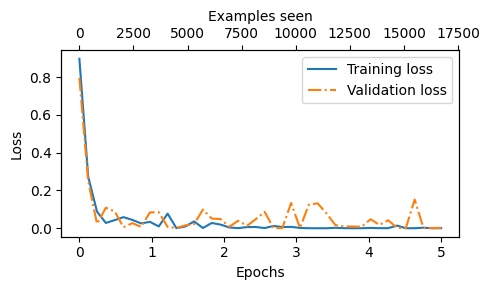

In [34]:
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

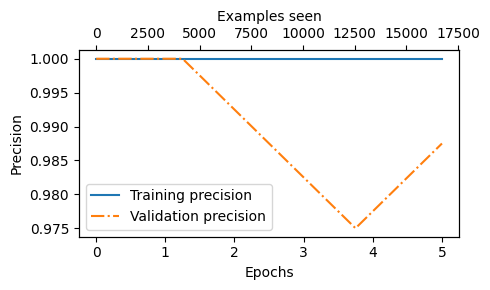

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_precision))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_precision))
plot_values(epochs_tensor, examples_seen_tensor, train_precision, val_precision, label='precision')

In [36]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [37]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, gpt, tokenizer, device, max_length=120
))

spam


In [38]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, gpt, tokenizer, device, max_length=120
))

not spam


### It's working!